In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [2]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/BBCA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,4180.0,4220.0,4170.0,4220.0,3802.38208,76474000
1,2017-12-19,4190.0,4250.0,4190.0,4220.0,3802.38208,76553500
2,2017-12-20,4210.0,4210.0,4175.0,4185.0,3770.84668,102963500
3,2017-12-21,4190.0,4230.0,4190.0,4220.0,3802.38208,61100000
4,2017-12-22,4235.0,4335.0,4195.0,4300.0,3874.46582,94573000


In [3]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [4]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,4220.0,4180.0,4220.0,4170.0
1,2017-12-19,4220.0,4190.0,4250.0,4190.0
2,2017-12-20,4185.0,4210.0,4210.0,4175.0
3,2017-12-21,4220.0,4190.0,4230.0,4190.0
4,2017-12-22,4300.0,4235.0,4335.0,4195.0
...,...,...,...,...,...
1489,2023-12-08,8750.0,8800.0,8850.0,8750.0
1490,2023-12-11,8750.0,8675.0,8775.0,8675.0
1491,2023-12-12,8700.0,8700.0,8750.0,8700.0
1492,2023-12-13,8675.0,8700.0,8750.0,8675.0


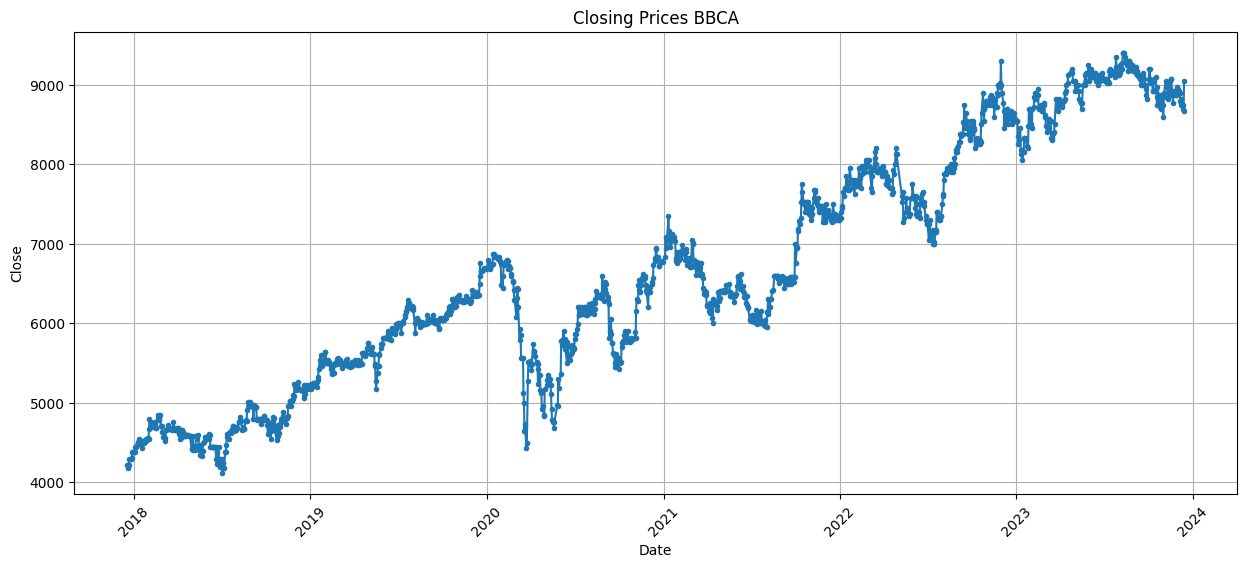

In [5]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices BBCA')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

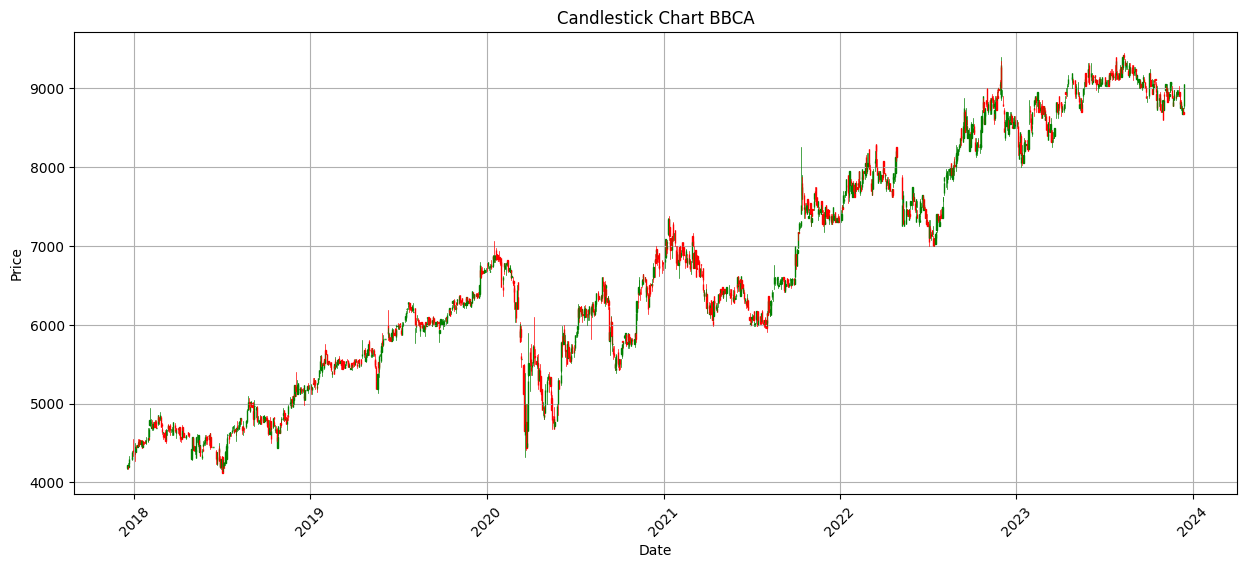

In [6]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart BBCA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

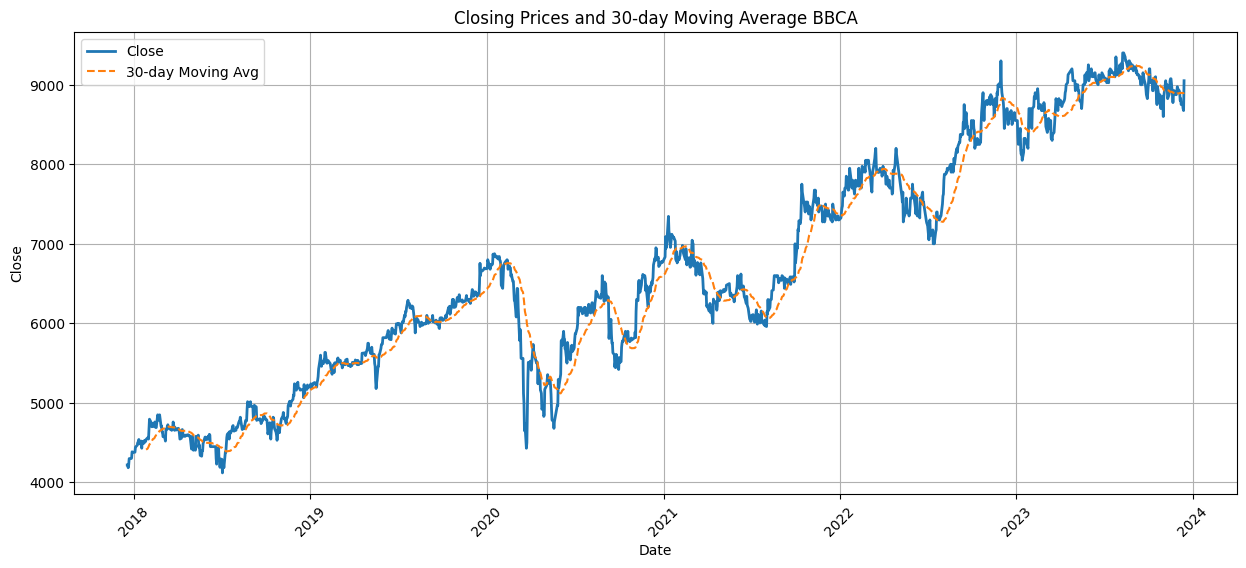

In [7]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average BBCA')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,4220.0,4180.0,4220.0,4170.0
1,2017-12-19,4220.0,4190.0,4250.0,4190.0
2,2017-12-20,4185.0,4210.0,4210.0,4175.0
3,2017-12-21,4220.0,4190.0,4230.0,4190.0
4,2017-12-22,4300.0,4235.0,4335.0,4195.0


In [9]:
new_df = specific_df.reset_index()['Close']

In [10]:
new_df

0       4220.0
1       4220.0
2       4185.0
3       4220.0
4       4300.0
         ...  
1489    8750.0
1490    8750.0
1491    8700.0
1492    8675.0
1493    9050.0
Name: Close, Length: 1494, dtype: float64

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

Partisi Data

In [12]:
train_size = int(len(scaled_data)*0.9) #90% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [13]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1284, 60)
(1284,)


Testing set size:-
(90, 60)
(90,)


(None, None)

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

Layer= 3

Dropout = 0.9

In [16]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [18]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100

41/41 [==============================] - 7s 61ms/step - loss: 0.1045 - val_loss: 0.1108
Epoch 2/100
41/41 [==============================] - 2s 42ms/step - loss: 0.0547 - val_loss: 0.0427
Epoch 3/100
41/41 [==============================] - 2s 41ms/step - loss: 0.0478 - val_loss: 0.0632
Epoch 4/100
41/41 [==============================] - 2s 43ms/step - loss: 0.0450 - val_loss: 0.0316
Epoch 5/100
41/41 [==============================] - 2s 43ms/step - loss: 0.0367 - val_loss: 0.0207
Epoch 6/100
41/41 [==============================] - 2s 44ms/step - loss: 0.0315 - val_loss: 0.0088
Epoch 7/100
41/41 [==============================] - 2s 41ms/step - loss: 0.0314 - val_loss: 0.0262
Epoch 8/100
41/41 [==============================] - 2s 43ms/step - loss: 0.0282 - val_loss: 0.0144
Epoch 9/100
41/41 [==============================] - 2s 43ms/step - loss: 0.0270 - val_loss: 0.0309
Epoch 10/100
41/41 [==============================] - 2s 41ms/step - loss: 0.0234 - val_loss: 0.014

In [20]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 17ms/step


In [21]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [22]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.051533353887697454
0.026390996344152113


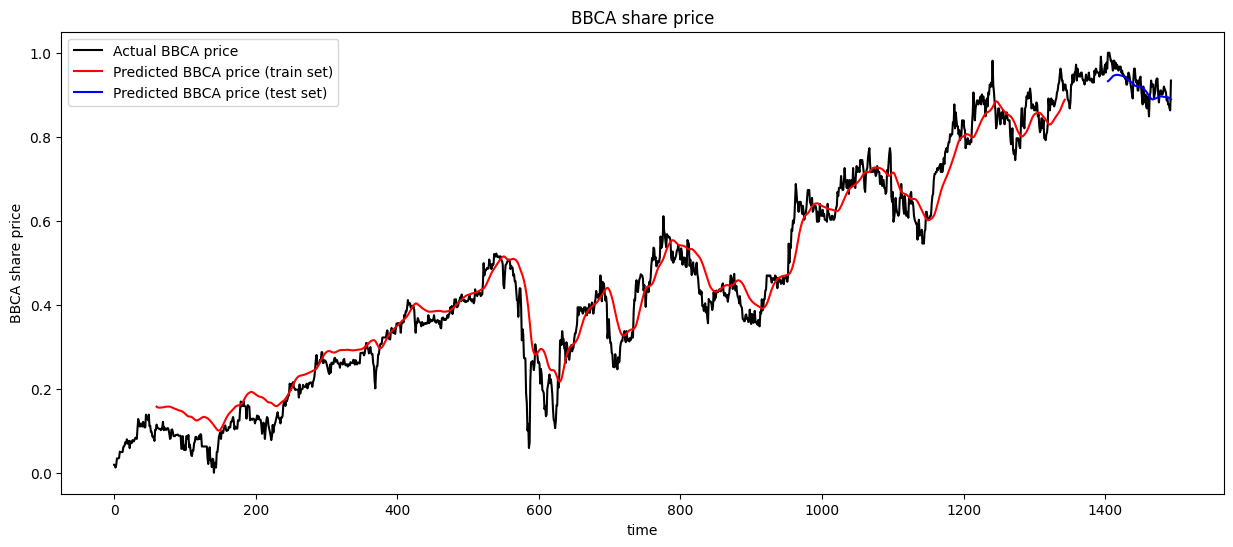

In [23]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [24]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 17ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8812.4130859375
Day 2: Predicted Price = 8802.8271484375
Day 3: Predicted Price = 8793.978515625
Day 4: Predicted Price = 8786.1884765625
Day 5: Predicted Price = 8779.486328125
Day 6: Predicted Price = 8773.7236328125
Day 7: Predicted Price = 8768.7216796875
Day 8: Predicted Price = 8764.275390625
Day 9: Predicted Price = 8760.0888671875
Day 10: Predicted Price = 8756.091796875
Day 11: Predicted Price = 8752.2470703125
Day 12: Predicted Price = 8748.5419921875
Day 13: Predicted Price = 8744.8984375
Day 14: Predicted Price = 8741.259765625
Day 15: Predicted Price = 8737.68359375
Day 16: Predicted Price = 8734.109375
Day 17: Predicted Price = 8730.4892578125
Day 18: Predicted Price = 8726.873046875
Day 19: Predicted Price = 8723.267578125
Day 20: Predicted Price = 8719.748046875
Day 21: Predicted Price = 8716.294921875
Day 22: Predicted Price = 8712.9033203125
Day 23: Predicted

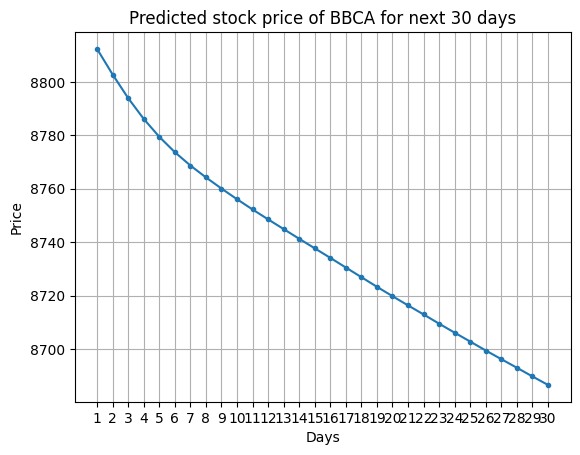

In [25]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [26]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 8ms/step - loss: 6.9648e-04
Validation Loss: 0.0006964848143979907
Validation MSE Loss: 0.0006964848143979907


In [27]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.051533353887697454
Testing RMSE: 0.026390996344152113


dropout = 0.8

In [28]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.8))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.8))

model.add(LSTM(units=50))
model.add(Dropout(0.8))

model.add(Dense(units=1))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [30]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
41/41 [==============================] - 7s 76ms/step - loss: 0.0596 - val_loss: 9.6600e-04
Epoch 2/100
41/41 [==============================] - 2s 49ms/step - loss: 0.0334 - val_loss: 0.0047
Epoch 3/100
41/41 [==============================] - 2s 43ms/step - loss: 0.0245 - val_loss: 0.0126
Epoch 4/100
41/41 [==============================] - 2s 42ms/step - loss: 0.0243 - val_loss: 0.0058
Epoch 5/100
41/41 [==============================] - 2s 42ms/step - loss: 0.0219 - val_loss: 0.0044
Epoch 6/100
41/41 [==============================] - 2s 41ms/step - loss: 0.0185 - val_loss: 0.0046
Epoch 7/100
41/41 [==============================] - 2s 41ms/step - loss: 0.0194 - val_loss: 0.0077
Epoch 8/100
41/41 [==============================] - 2s 43ms/step - loss: 0.0169 - val_loss: 0.0150
Epoch 9/100
41/41 [==============================] - 2s 41ms/step - loss: 0.0177 - val_loss: 0.0094
Epoch 10/100
41/41 [==============================] - 2s 44ms/step - loss: 0.0169 - val_loss: 0.

In [32]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 16ms/step


In [33]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [34]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.042654499857897134
0.023606881595136842


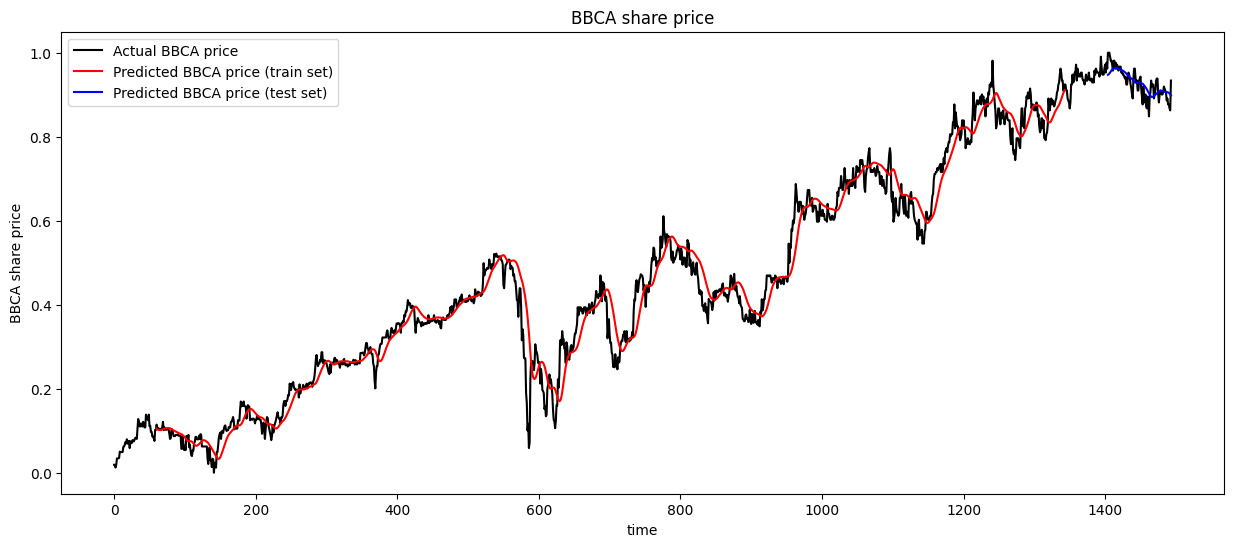

In [35]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [36]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 31ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8863.693359375
Day 2: Predicted Price = 8851.689453125
Day 3: Predicted Price = 8841.9697265625
Day 4: Predicted Price = 8834.8369140625
Day 5: Predicted Price = 8830.05078125
Day 6: Predicted Price = 8827.1484375
Day 7: Predicted Price = 8825.6279296875
Day 8: Predicted Price = 8825.041015625
Day 9: Predicted Price = 8825.0107421875
Day 10: Predicted Price = 8825.2890625
Day 11: Predicted Price = 8825.708984375
Day 12: Predicted Price = 8826.173828125
Day 13: Predicted Price = 8826.611328125
Day 14: Predicted Price = 8826.984375
Day 15: Predicted Price = 8827.296875
Day 16: Predicted Price = 8827.5419921875
Day 17: Predicted Price = 8827.71484375
Day 18: Predicted Price = 8827.837890625
Day 19: Predicted Price = 8827.921875
Day 20: Predicted Price = 8827.9892578125
Day 21: Predicted Price = 8828.04296875
Day 22: Predicted Price = 8828.087890625
Day 23: Predicted Price = 8828.

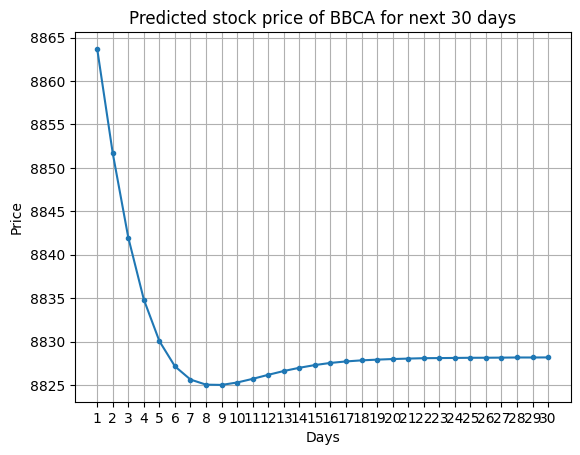

In [37]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [38]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 18ms/step - loss: 5.5728e-04
Validation Loss: 0.000557284860406071
Validation MSE Loss: 0.000557284860406071


In [39]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.042654499857897134
Testing RMSE: 0.023606881595136842


dropout = 0.7

In [40]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.7))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.7))

model.add(LSTM(units=50))
model.add(Dropout(0.7))

model.add(Dense(units=1))

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [42]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [43]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
41/41 [==============================] - 9s 82ms/step - loss: 0.0524 - val_loss: 0.0032
Epoch 2/100
41/41 [==============================] - 2s 52ms/step - loss: 0.0232 - val_loss: 0.0129
Epoch 3/100
41/41 [==============================] - 2s 58ms/step - loss: 0.0189 - val_loss: 0.0024
Epoch 4/100
41/41 [==============================] - 2s 58ms/step - loss: 0.0180 - val_loss: 0.0011
Epoch 5/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0141 - val_loss: 0.0014
Epoch 6/100
41/41 [==============================] - 2s 55ms/step - loss: 0.0141 - val_loss: 0.0015
Epoch 7/100
41/41 [==============================] - 2s 55ms/step - loss: 0.0156 - val_loss: 0.0117
Epoch 8/100
41/41 [==============================] - 2s 53ms/step - loss: 0.0133 - val_loss: 0.0030
Epoch 9/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0119 - val_loss: 0.0018
Epoch 10/100
41/41 [==============================] - 2s 52ms/step - loss: 0.0092 - val_loss: 0.0013

In [44]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 22ms/step


In [45]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [46]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.04252277640826578
0.022594808251068018


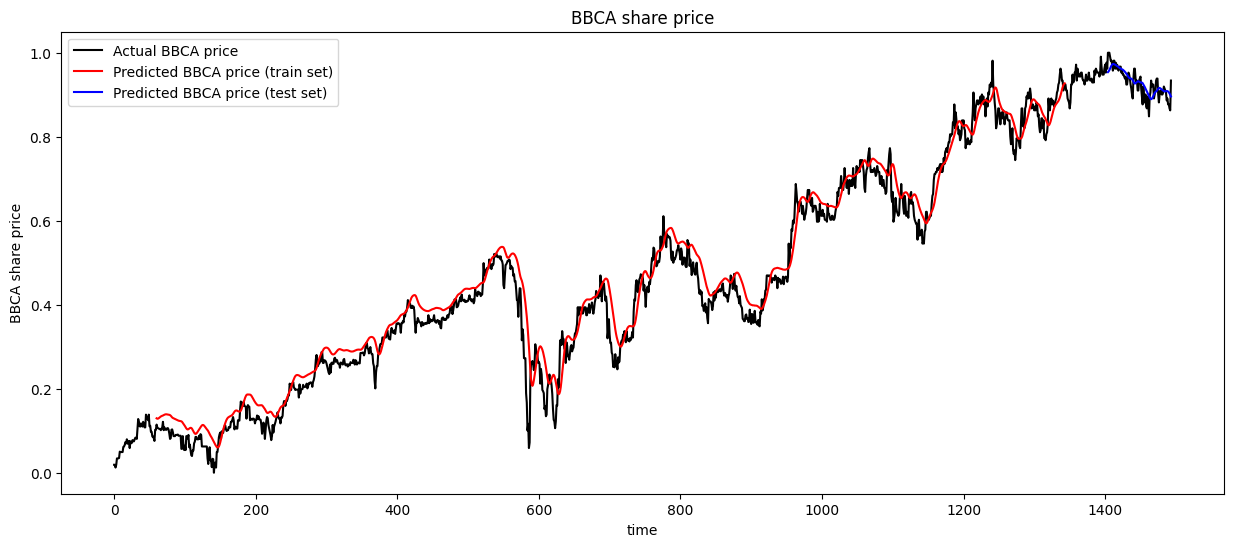

In [47]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [48]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 90ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8850.13671875
Day 2: Predicted Price = 8833.4912109375
Day 3: Predicted Price = 8822.431640625
Day 4: Predicted Price = 8816.5634765625
Day 5: Predicted Price = 8814.64453125
Day 6: Predicted Price = 8815.337890625
Day 7: Predicted Price = 8817.537109375
Day 8: Predicted Price = 8820.455078125
Day 9: Predicted Price = 8823.595703125
Day 10: Predicted Price = 8826.6884765625
Day 11: Predicted Price = 8829.611328125
Day 12: Predicted Price = 8832.328125
Day 13: Predicted Price = 8834.8505859375
Day 14: Predicted Price = 8837.2080078125
Day 15: Predicted Price = 8839.4306640625
Day 16: Predicted Price = 8841.548828125
Day 17: Predicted Price = 8843.58203125
Day 18: Predicted Price = 8845.552734375
Day 19: Predicted Price = 8847.466796875
Day 20: Predicted Price = 8849.3359375
Day 21: Predicted Price = 8851.1650390625
Day 22: Predicted Price = 8852.9580078125
Day 23: Predicted Pri

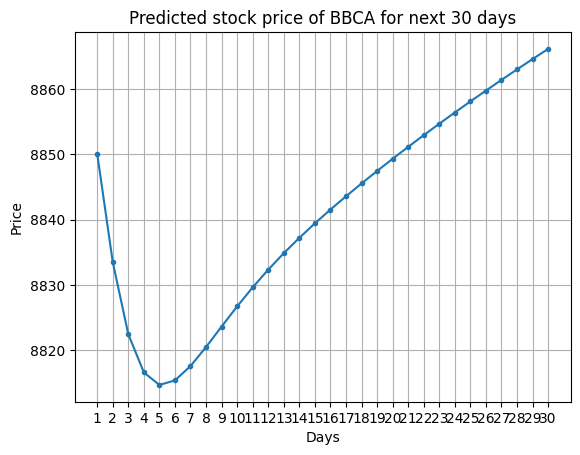

In [49]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [50]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 27ms/step - loss: 5.1053e-04
Validation Loss: 0.0005105253658257425
Validation MSE Loss: 0.0005105253658257425


In [51]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.04252277640826578
Testing RMSE: 0.022594808251068018


dropout = 0.6

In [52]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.6))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.6))

model.add(LSTM(units=50))
model.add(Dropout(0.6))

model.add(Dense(units=1))

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [54]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [55]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
41/41 [==============================] - 31s 228ms/step - loss: 0.0464 - val_loss: 0.0058
Epoch 2/100
41/41 [==============================] - 3s 73ms/step - loss: 0.0149 - val_loss: 0.0024
Epoch 3/100
41/41 [==============================] - 3s 69ms/step - loss: 0.0137 - val_loss: 0.0023
Epoch 4/100
41/41 [==============================] - 3s 74ms/step - loss: 0.0141 - val_loss: 0.0018
Epoch 5/100
41/41 [==============================] - 3s 67ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 6/100
41/41 [==============================] - 3s 73ms/step - loss: 0.0113 - val_loss: 8.7397e-04
Epoch 7/100
41/41 [==============================] - 3s 73ms/step - loss: 0.0099 - val_loss: 7.6840e-04
Epoch 8/100
41/41 [==============================] - 3s 68ms/step - loss: 0.0112 - val_loss: 0.0021
Epoch 9/100
41/41 [==============================] - 3s 74ms/step - loss: 0.0104 - val_loss: 0.0020
Epoch 10/100
41/41 [==============================] - 3s 68ms/step - loss: 0.0099 - val_lo

In [56]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 18ms/step


In [57]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [58]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.03340073854236248
0.02201751910597185


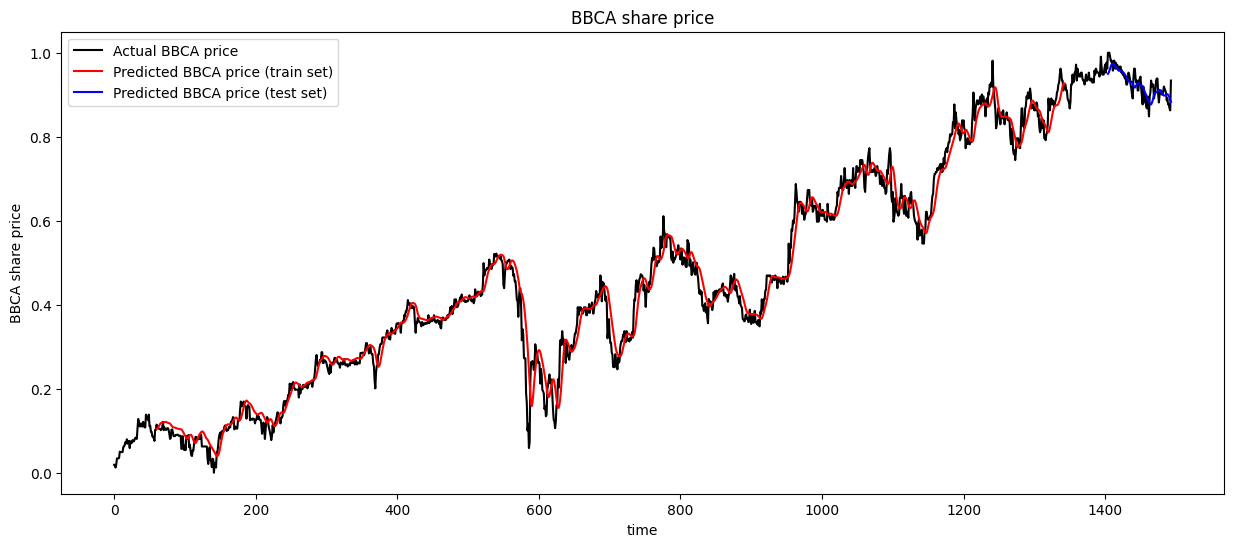

In [59]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [60]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 75ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8782.83203125
Day 2: Predicted Price = 8759.0556640625
Day 3: Predicted Price = 8741.861328125
Day 4: Predicted Price = 8730.6396484375
Day 5: Predicted Price = 8723.78125
Day 6: Predicted Price = 8719.6142578125
Day 7: Predicted Price = 8716.814453125
Day 8: Predicted Price = 8714.494140625
Day 9: Predicted Price = 8712.1513671875
Day 10: Predicted Price = 8709.556640625
Day 11: Predicted Price = 8706.6474609375
Day 12: Predicted Price = 8703.4482421875
Day 13: Predicted Price = 8700.015625
Day 14: Predicted Price = 8696.4130859375
Day 15: Predicted Price = 8692.6982421875
Day 16: Predicted Price = 8688.9111328125
Day 17: Predicted Price = 8685.0849609375
Day 18: Predicted Price = 8681.2421875
Day 19: Predicted Price = 8677.3994140625
Day 20: Predicted Price = 8673.56640625
Day 21: Predicted Price = 8669.75390625
Day 22: Predicted Price = 8665.966796875
Day 23: Predicted Pric

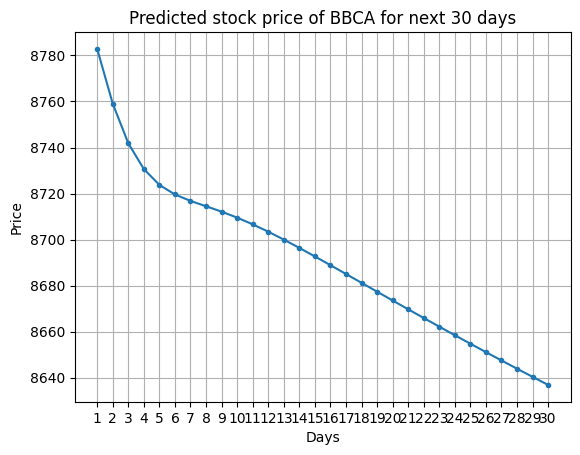

In [61]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [62]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 26ms/step - loss: 4.8477e-04
Validation Loss: 0.0004847711243201047
Validation MSE Loss: 0.0004847711243201047


In [63]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.03340073854236248
Testing RMSE: 0.02201751910597185


: 